In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data import *
from minibatch import *

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
dataset = get_dataset(type="64")

Total number of images in dataset5:  65774


In [3]:
train_data, train_label_onehot, validation_data, validation_label_onehot, test_data, test_label_onehot \
    = split_train_validation_test(dataset)  

Train data size:  60040
Train label size:  60040
Validation data size:  2500
Validation label size:  2500
Test data size:  3234
Test label size:  3234


In [4]:
X_validation, y_validation = get_data(validation_data, validation_label_onehot)

In [5]:
X_train, y_train = get_data(train_data, train_label_onehot)

In [6]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [7]:
def get_mini_batches(data, label, batch_size = 128):
    shuffle_in_unison(data, label)
    n = len(data)
    mini_batches = [(data[k:k+batch_size], label[k:k+batch_size]) for k in range(0, n, batch_size)]
    return mini_batches

mini_batches = get_mini_batches(X_train, y_train)
print(len(mini_batches))

470


#  neural network

In [20]:
from minibatch import *

import tensorflow as tf

print("(WIDTH, HEIGHT)=",(WIDTH,HEIGHT))
C = 24

X = tf.placeholder(tf.float32, [None, WIDTH, HEIGHT, 3])
Y_ = tf.placeholder(tf.float32, [None, C])

# variable learning rate
learning_rate = tf.placeholder(tf.float32)

D = WIDTH*HEIGHT*3 #120*120*3


# Weights initialised with small random values

W1 = tf.Variable(tf.zeros((D, C)))  # 784 = 28 * 28
#W1 = tf.Variable(tf.zeros((D,C)))
B1 = tf.Variable(tf.zeros([C]))

XX = tf.reshape(X, [-1, D])

Ylogits = tf.matmul(XX, W1) + B1


# cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
softmax = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(softmax)

gamma = 0.5
reg = gamma*tf.nn.l2_loss(W1)


total_loss = cross_entropy + reg

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Ylogits, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(total_loss)

saver =tf.train.Saver()

#Initialisation
init = tf.global_variables_initializer()

(WIDTH, HEIGHT)= (64, 64)


# Check for loss

In [21]:
with tf.Session() as sess:
    sess.run(init)   
    
    #check initial loss
    cross_entropy_loss =  sess.run(cross_entropy, feed_dict={X: X_validation, Y_: y_validation})
    print(cross_entropy_loss)
    
print("check = ", -np.log(1/24))

3.17807
check =  3.17805383035


In [22]:
import time
BATCH_SIZE = 128
EPOCHS = 500

In [23]:
train_losses = []
train_accuracies = []
validation_accuracies = []

#Initialisation
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    lr = 0.03

    for k in range(EPOCHS):
        
        if lr > 0.001:
            lr *= 0.99
            
        print(k, ": ", "learning rate = ", lr)
        mini_batches = get_mini_batches(X_train, y_train, batch_size = BATCH_SIZE)
        
        i = 0
        print("--------------------------")
        
        for mini_batch in mini_batches:
            # load batch of images and correct answers

            batch_X, batch_Y = mini_batch
            
            sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, learning_rate: lr})

            if i >= 0 and i % 100 == 0:
                cross_entropy_loss, reg_loss = sess.run([cross_entropy, reg], feed_dict={X: batch_X, Y_: batch_Y})
                loss = cross_entropy_loss + reg_loss
                train_losses.append(loss)             
                print(i, ":", " cross entropy loss = ", cross_entropy_loss, "; reg = ", reg_loss)            
            i+= 1
            
        #saver.save(sess, "./tmp/one_layer/model_image64_adam.ckpt")
    
        train_accuracy = sess.run(accuracy, feed_dict={X: X_train[:5000], Y_: y_train[:5000]})
        validation_accuracy = sess.run(accuracy, feed_dict={X: X_validation, Y_: y_validation})
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
    
        print(k, ": train_accuracy: ", train_accuracy, "; validation_accuracy: ", validation_accuracy)
   
    # Save the variables to disk.
    save_path = saver.save(sess, "./tmp/one_layer/model_image64_adam_reg01.ckpt")
    print("Model saved in file: %s" % save_path)

0 :  learning rate =  0.029699999999999997
--------------------------
0 :  cross entropy loss =  1550.29 ; reg =  65.0372
100 :  cross entropy loss =  1347.35 ; reg =  763.609
200 :  cross entropy loss =  1366.51 ; reg =  852.551
300 :  cross entropy loss =  1793.46 ; reg =  876.357
400 :  cross entropy loss =  1146.48 ; reg =  830.008
0 : train_accuracy:  0.4748 ; validation_accuracy:  0.4968
1 :  learning rate =  0.029403
--------------------------
0 :  cross entropy loss =  2497.04 ; reg =  874.136
100 :  cross entropy loss =  1542.17 ; reg =  872.065
200 :  cross entropy loss =  1831.58 ; reg =  861.999
300 :  cross entropy loss =  1222.23 ; reg =  862.628
400 :  cross entropy loss =  1385.35 ; reg =  904.383
1 : train_accuracy:  0.5116 ; validation_accuracy:  0.5348
2 :  learning rate =  0.029108969999999998
--------------------------
0 :  cross entropy loss =  2205.33 ; reg =  861.474
100 :  cross entropy loss =  2173.63 ; reg =  919.343
200 :  cross entropy loss =  1757.84 ; reg

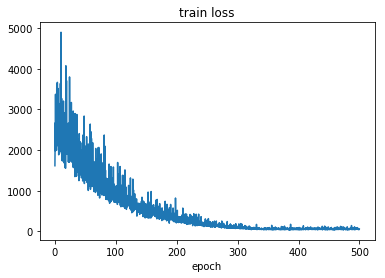

In [37]:
plt.plot(np.arange(0,500,0.2), train_losses)
plt.title("train loss")
plt.xlabel("epoch")

(0.2, 1)

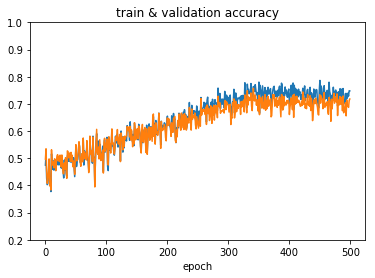

In [43]:
plt.plot(train_accuracies, label="train")
plt.plot(validation_accuracies, label="validation")
plt.title("train & validation accuracy")
plt.xlabel("epoch")
plt.ylim([0.2,1])

In [26]:
def test_accuracy(model_path):
    with tf.Session() as sess:
        # Restore variables from disk.
        saver.restore(sess, model_path)
        print("Model restored.")
        N = len(test_data)    
        batch_size = 128
        batch_number = int(N/batch_size) + 1
        sum_correct = 0.
        for i in range(batch_number):
            batch_X, batch_Y = get_batch(test_data, test_label_onehot, i)
            n = batch_X.shape[0]
            a = sess.run(accuracy, feed_dict={X: batch_X, Y_: batch_Y})
            sum_correct += a*n
        
        test_accuracy = sum_correct/N
        print("final test accuracy = ", test_accuracy)
        
test_accuracy("./tmp/one_layer/model_image64_adam_reg01.ckpt")

INFO:tensorflow:Restoring parameters from ./tmp/one_layer/model_image64_adam_reg01.ckpt
Model restored.
final test accuracy =  0.712739641311


## Final Result
- 1 layer
- regularlization = 0.5
- batch 128
- 500 epoches

### Test accuracy = 0.71